In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
import datetime
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import auto_arima

# Monthly

In [ ]:
monthly = pd.read_csv('/content/drive/MyDrive/Telkom/Seller Register - Monthly.csv')

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)
    else:
      plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

## Visualization

In [ ]:
series = monthly['total']
time = monthly.index

In [ ]:
monthly

,tahun,bulan,total
0,2020,6,4257
1,2020,7,8466
2,2020,8,710
3,2020,9,678
4,2020,10,704
5,2020,11,497
6,2020,12,527
7,2021,1,728
8,2021,2,1076
9,2021,3,849


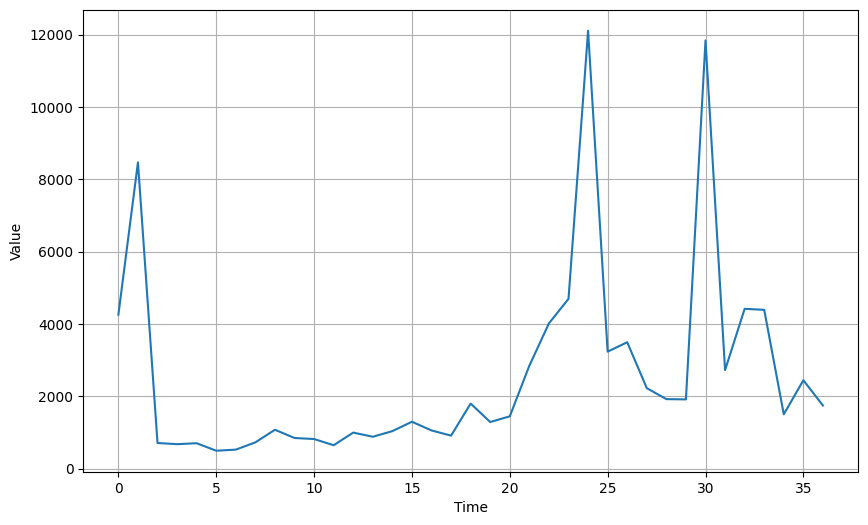

In [ ]:
plot_series(time, series)

## Stationarity
syaratnya:
- mean konstan
- std dev konstan
- tidak ada seasonality

In [ ]:
def plot_rolling_statistics(data, window=12):
    df = pd.DataFrame(data, columns=['Value'])

    rolling_mean = df['Value'].rolling(window=window).mean()
    rolling_std = df['Value'].rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(df['Value'], label='Original')
    plt.plot(rolling_mean, label='Rolling Mean (window={})'.format(window))
    plt.plot(rolling_std, label='Rolling Std (window={})'.format(window))
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

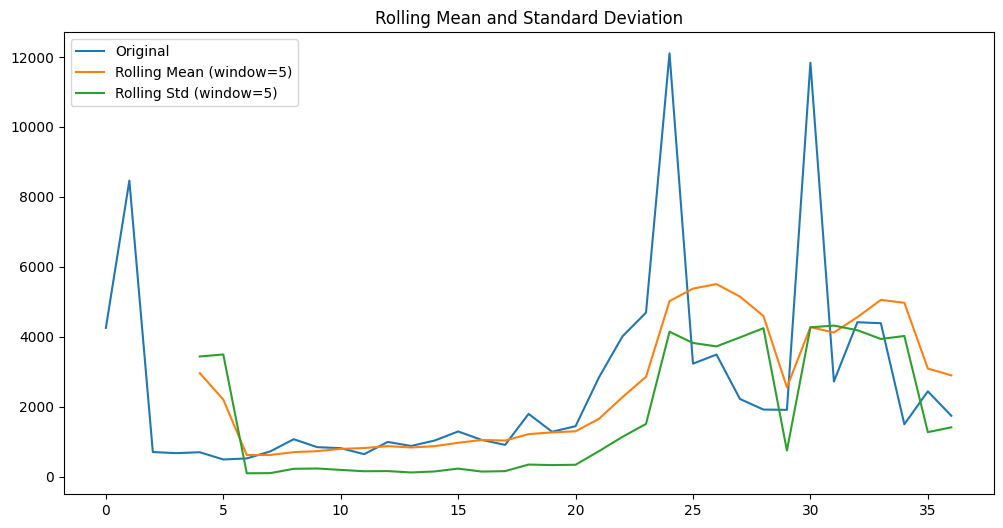

In [ ]:
plot_rolling_statistics(np.array(series), window=5)

Bisa dilihat bahwa nilai dari mean dan standar deviasi pada tiap observasi tidak konstan/sama sehingga perlu kita lakukan transformasi supaya datanya stationary, caranya adalah cek **unit roots**, salah satu cara untuk mencari unit roots adalah dengan **ADF**

## ADF

In [ ]:
adfuller(series)

(-4.446712849998697,
 0.0002451506331885602,
 0,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 490.2901440399526)

Karena nilai p-value < 0.05 maka kita berhasil reject H0, di mana H0 adalah time series mempunyai unit root. Jadi, kesimpulan dari time series monthly bertipe **stationary**, walaupun pada perbandingan rolling mean dan std tadi hasilnya tidak konstan, tapi kita lebih pilih cara yang robust

## Decomposition

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_time_series_decomposition(data, freq):
    decomposition = seasonal_decompose(data, model='additive', period=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.figure(figsize=(5, 5))

    plt.subplot(411)
    plt.plot(data)
    plt.title('Original Time Series')

    plt.subplot(412)
    plt.plot(trend)
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(seasonal)
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(residual)
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()


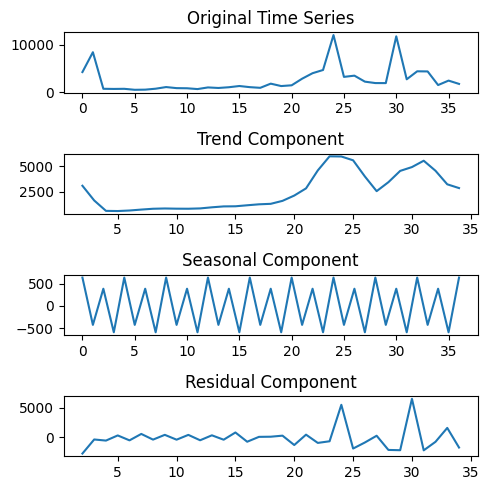

In [ ]:
plot_time_series_decomposition(np.array(series), freq=4)

## Autocorrelation

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


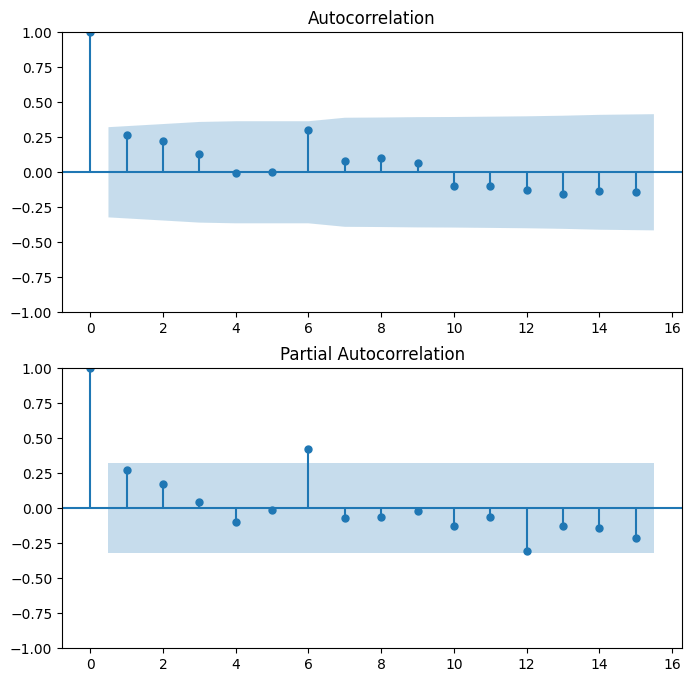

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

plot_acf(series, lags=15, ax=ax[0])
plot_pacf(series, lags=15, ax=ax[1])

plt.show()

Dari plot ACF dan PACF bisa dilihat kemungkinan penggunaan model yang bisa digunakan adalah **AR, ARMA, dan ARIMA** dengan ordo AR = 6 karena pada plot ACF, nilai dari lag yang memenuhi hanya lag = 0 yang artinya time series berkorelasi dengan dirinya sendiri dan model **MA** tidak cocok digunakan.
Intusinya kenapa tidak bisa digunakan:
- X(t) = μ + e(t)
Karena tidak memperhitungkan lag-lag sebelumnya maka prediksi hanya menambahkan rata-rata dengan error sekarang.

## AR dan ARMA
Karena tidak ada lag yang memenuhi pada MA maka saya pikir AR(6) == ARMA(6,0) == ARIMA(6,0,0) ?

Jika diturunkan maka persamaannya menjadi:
- AR(6) = X(t) = C + φ(6)X(t-6) + ε(t)
- ARMA(6,0) = X(t) = C + φ(6)X(t-6) + ε(t)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arma_model = ARIMA(series, order=([0,0,0,0,0,1],0, 0))

In [ ]:
arma_model_fit = arma_model.fit()
arma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   37
Model:               ARIMA([6], 0, 0)   Log Likelihood                -343.916
Date:                Mon, 03 Jul 2023   AIC                            693.832
Time:                        02:23:44   BIC                            698.665
Sample:                             0   HQIC                           695.536
                                 - 37                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2600.3784    952.712      2.729      0.006     733.097    4467.660
ar.L6          0.3205      0.105      3.048      0.002       0.114       0.527
sigma2      6.611e+06   1.31e+06      5.048      0.000    4.04e+06    9.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.53   Jarque-Bera (JB):                45.45
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             1.83
Prob(H) (two-sided):                  0.86   Kurtosis:                         7.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Karena nilai dari p-value koefisien di atas < 0.05 semua maka persamannya:
- X(t) = 2600.3784 + 0.3205 * X(t-6) + ε(t)

In [ ]:
#get prediction start and end dates
pred_start_date = monthly.index[0]
pred_end_date = monthly.index[-1]

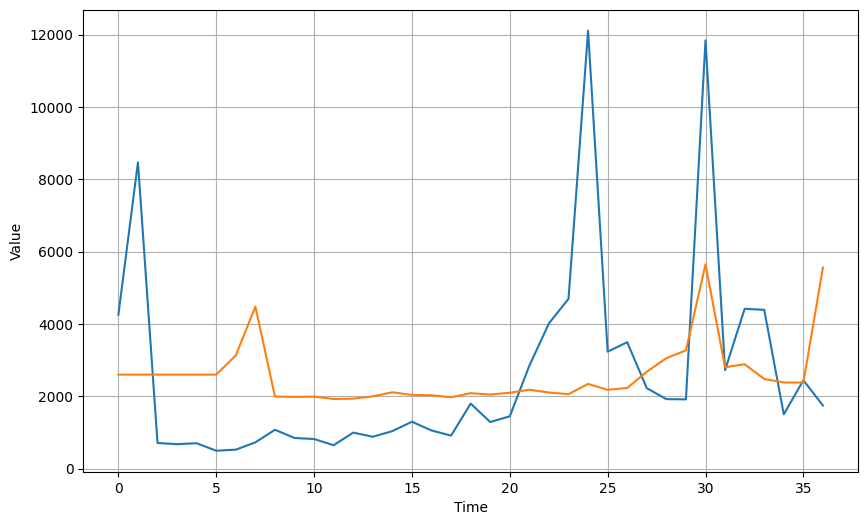

In [ ]:
predictions = arma_model_fit.predict(start=pred_start_date, end=pred_end_date)
plot_series(time, (series, predictions))

In [ ]:
predictions

0     2600.378383
1     2600.378383
2     2600.378383
3     2600.378383
4     2600.378383
5     2600.378383
6     3131.265224
7     4480.096298
8     1994.581019
9     1984.326185
10    1992.658238
11    1926.322283
12    1935.936190
13    2000.349363
14    2111.870678
15    2039.125452
16    2029.832009
17    1975.032743
18    2086.874521
19    2050.021213
20    2100.013526
21    2183.013585
22    2105.781870
23    2059.955583
24    2343.886286
25    2180.449877
26    2231.083117
27    2679.732085
28    3054.353972
29    3271.628258
30    5646.263149
31    2803.751478
32    2887.392464
33    2480.403758
34    2383.303303
35    2381.060058
36    5560.058455
Name: predicted_mean, dtype: float64

<ipython-input-126-28429f2bb3c0>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_rolling = pd.Series()
<ipython-input-126-28429f2bb3c0>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_rolling = prediction_rolling.append(pd.Series([new_element], index=[new_index]), ignore_index=True)
<ipython-input-126-28429f2bb3c0>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_rolling = prediction_rolling.append(pd.Series([new_element], index=[new_index]), ignore_index=True)
<ipython-input-126-28429f2bb3c0>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_rolling = predictio

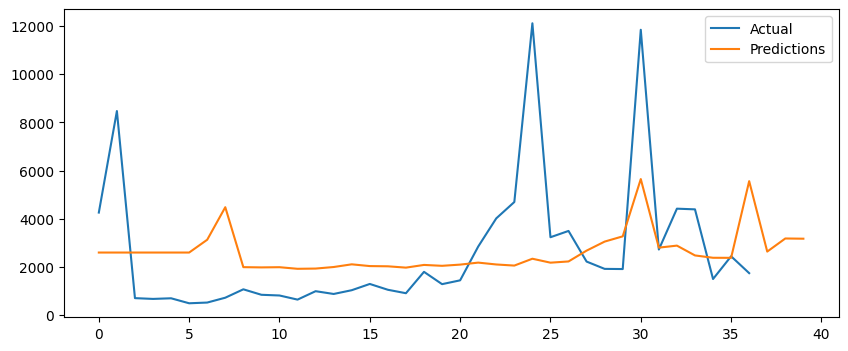

In [ ]:
prediction_rolling = pd.Series()
train_data = series
for end_date in pd.RangeIndex(start=0, stop=40, step=1):
    model = ARIMA(train_data, order=([0,0,0,0,0,1], 0, 0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date, end_date)
    new_element = pred.loc[end_date]
    new_index = 'D'
    prediction_rolling = prediction_rolling.append(pd.Series([new_element], index=[new_index]), ignore_index=True)

plt.figure(figsize=(10, 4))
plt.plot(series)
plt.plot(prediction_rolling)

plt.legend(["Actual", "Predictions"])


In [ ]:
prediction_rolling

0     2600.378383
1     2600.378383
2     2600.378383
3     2600.378383
4     2600.378383
5     2600.378383
6     3131.265224
7     4480.096298
8     1994.581019
9     1984.326185
10    1992.658238
11    1926.322283
12    1935.936190
13    2000.349363
14    2111.870678
15    2039.125452
16    2029.832009
17    1975.032743
18    2086.874521
19    2050.021213
20    2100.013526
21    2183.013585
22    2105.781870
23    2059.955583
24    2343.886286
25    2180.449877
26    2231.083117
27    2679.732085
28    3054.353972
29    3271.628258
30    5646.263149
31    2803.751478
32    2887.392464
33    2480.403758
34    2383.303303
35    2381.060058
36    5560.058455
37    2640.315068
38    3183.180319
39    3174.207339
dtype: float64

In [ ]:
print('Monthly')
mae = abs(monthly['total']- prediction_rolling.loc[0:37]).mean()
mse = np.mean((monthly['total']- prediction_rolling.loc[0:37])**2)
rmse = np.sqrt(mse)
print("MAE:", mae)
print("RMSE:", rmse)

Monthly
MAE: 1851.313500256228
RMSE: 2637.6677432161323


## ARIMA

In [ ]:
model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=691.316, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=685.635, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=678.921, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=689.345, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=681.316, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=677.001, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=678.558, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=678.638, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=683.513, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.060 seconds
                               SARIMAX Results                                
Dep. Variable:                   

In [ ]:
arima_model = ARIMA(series, order=(1,0,0))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   37
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -344.443
Date:                Mon, 03 Jul 2023   AIC                            694.886
Time:                        02:23:49   BIC                            699.719
Sample:                             0   HQIC                           696.590
                                 - 37                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2600.3784   1362.355      1.909      0.056     -69.789    5270.546
ar.L1          0.2634      0.201      1.308      0.191      -0.131       0.658
sigma2      7.248e+06    1.9e+06      3.817      0.000    3.53e+06     1.1e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                75.91
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             2.33
Prob(H) (two-sided):                  0.35   Kurtosis:                         8.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_model1 = ARIMA(series, order=(0,1,1))
arima_model_fit1 = arima_model1.fit()
arima_model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   37
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -336.500
Date:                Mon, 03 Jul 2023   AIC                            677.001
Time:                        02:23:49   BIC                            680.168
Sample:                             0   HQIC                           678.106
                                 - 37                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7841      0.128     -6.124      0.000      -1.035      -0.533
sigma2      7.392e+06   1.09e+06      6.759      0.000    5.25e+06    9.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                51.18
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                             2.02
Prob(H) (two-sided):                  0.33   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_start_date, pred_end_date

(0, 36)

In [ ]:
predictions = arima_model_fit1.predict(start=pred_start_date, end=pred_end_date) # (0,1,1)
predictions

0        0.000000
1     2349.712925
2     4670.385001
3     3462.428830
4     2718.690902
5     2222.744447
6     1818.792464
7     1525.665824
8     1348.095879
9     1288.233980
10    1192.299820
11    1111.347098
12    1011.090191
13    1008.256459
14     981.169391
15     993.667444
16    1059.412410
17    1058.891383
18    1027.602693
19    1194.383452
20    1215.028404
21    1265.328502
22    1607.030426
23    2127.340865
24    2681.691908
25    4716.150005
26    4396.376051
27    4201.989072
28    3775.382762
29    3375.462728
30    3060.372270
31    4954.984423
32    4473.542522
33    4461.767080
34    4446.488842
35    3811.005219
36    3516.091948
Name: predicted_mean, dtype: float64

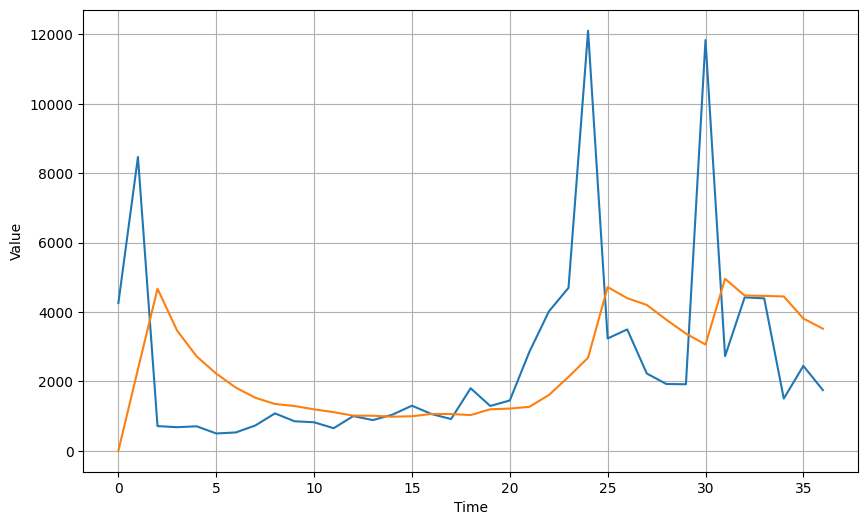

In [ ]:
plot_series(time, (series, predictions))

In [ ]:
print('Monthly')
mae = abs(monthly['total']- predictions).mean()
mse = np.mean((monthly['total']- predictions)**2)
rmse = np.sqrt(mse)
print("MAE:", mae)
print("RMSE:", rmse)

Monthly
MAE: 1813.682352912171
RMSE: 2854.8375840279614


In [ ]:
predictions = arima_model_fit.predict(start=pred_start_date, end=pred_end_date) # (1,0,0)
predictions

0     2600.378380
1     3036.713939
2     4145.317344
3     2102.473911
4     2094.045470
5     2100.893578
6     2046.372099
7     2054.273763
8     2107.214909
9     2198.874207
10    2139.084952
11    2131.446678
12    2086.407195
13    2178.329882
14    2148.040171
15    2189.128822
16    2257.346518
17    2193.869820
18    2156.205224
19    2389.567689
20    2255.239408
21    2296.854836
22    2665.599138
23    2973.500630
24    3152.078228
25    5103.789141
26    2767.530599
27    2836.275072
28    2501.771312
29    2421.964510
30    2420.120788
31    5032.937557
32    2633.202317
33    3079.382923
34    3072.008037
35    2311.341219
36    2559.453457
Name: predicted_mean, dtype: float64

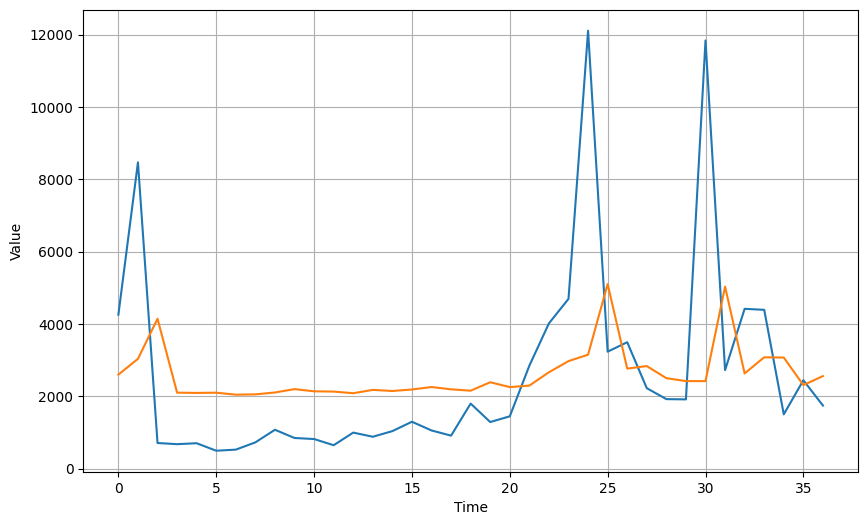

In [ ]:
plot_series(time, (series, predictions))

In [ ]:
print('Monthly')
mae = abs(monthly['total']- predictions).mean()
mse = np.mean((monthly['total']- predictions)**2)
rmse = np.sqrt(mse)
print("MAE:", mae)
print("RMSE:", rmse)

Monthly
MAE: 1791.9358845666122
RMSE: 2669.505040783138


Diputuskan untuk memakai ARIMA(1,0,0) untuk predict 3 bulan ke depan

<ipython-input-139-bd31cac24bf4>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_rolling = pd.Series()
<ipython-input-139-bd31cac24bf4>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_rolling = prediction_rolling.append(pd.Series([new_element], index=[new_index]), ignore_index=True)
<ipython-input-139-bd31cac24bf4>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_rolling = prediction_rolling.append(pd.Series([new_element], index=[new_index]), ignore_index=True)
<ipython-input-139-bd31cac24bf4>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_rolling = predictio

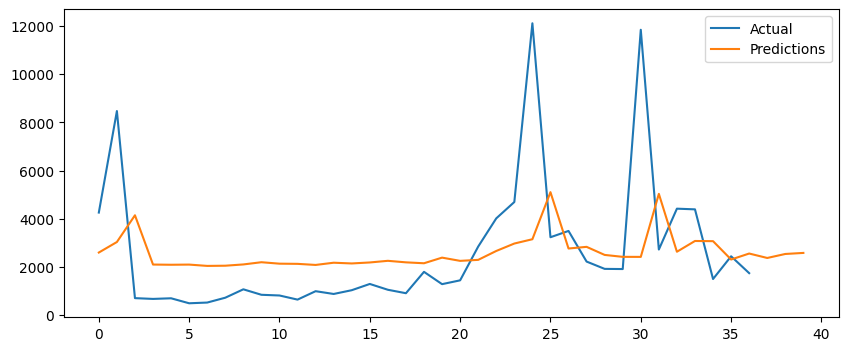

In [ ]:
prediction_rolling = pd.Series()
train_data = series
for end_date in pd.RangeIndex(start=0, stop=40, step=1):
    model = ARIMA(train_data, order=(1,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date, end_date)
    new_element = pred.loc[end_date]
    new_index = 'D'
    prediction_rolling = prediction_rolling.append(pd.Series([new_element], index=[new_index]), ignore_index=True)

plt.figure(figsize=(10, 4))
plt.plot(series)
plt.plot(prediction_rolling)

plt.legend(["Actual", "Predictions"])


In [ ]:
prediction_rolling

0     2600.378380
1     3036.713939
2     4145.317344
3     2102.473911
4     2094.045470
5     2100.893578
6     2046.372099
7     2054.273763
8     2107.214909
9     2198.874207
10    2139.084952
11    2131.446678
12    2086.407195
13    2178.329882
14    2148.040171
15    2189.128822
16    2257.346518
17    2193.869820
18    2156.205224
19    2389.567689
20    2255.239408
21    2296.854836
22    2665.599138
23    2973.500630
24    3152.078228
25    5103.789141
26    2767.530599
27    2836.275072
28    2501.771312
29    2421.964510
30    2420.120788
31    5032.937557
32    2633.202317
33    3079.382923
34    3072.008037
35    2311.341219
36    2559.453457
37    2375.344695
38    2541.107030
39    2584.766971
dtype: float64

In [ ]:
print('Monthly')
mae = abs(monthly['total']- prediction_rolling.loc[0:37]).mean()
mse = np.mean((monthly['total']- prediction_rolling.loc[0:37])**2)
rmse = np.sqrt(mse)
print("MAE:", mae)
print("RMSE:", rmse)

Monthly
MAE: 1791.9358845666122
RMSE: 2669.505040783138


# Quarterly

In [ ]:
quarterly = pd.read_csv('/content/drive/MyDrive/Telkom/Seller Register - Quarterly.csv')

## Visualization

In [ ]:
series = quarterly['total']
time = quarterly.index

In [ ]:
quarterly

,tahun,kuarter,total
0,2020,2,4257
1,2020,3,9854
2,2020,4,1728
3,2021,1,2653
4,2021,2,2467
5,2021,3,3220
6,2021,4,3771
7,2022,1,5586
8,2022,2,20817
9,2022,3,8957


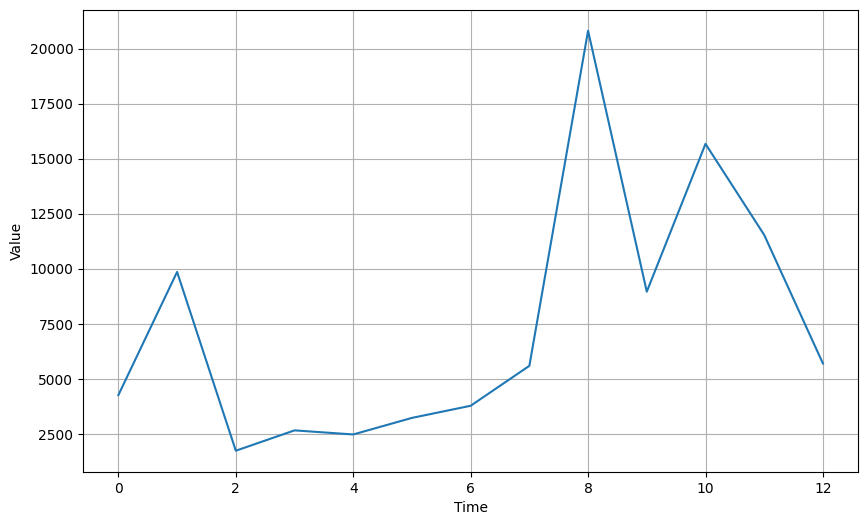

In [ ]:
plot_series(time, series)

## Stationarity

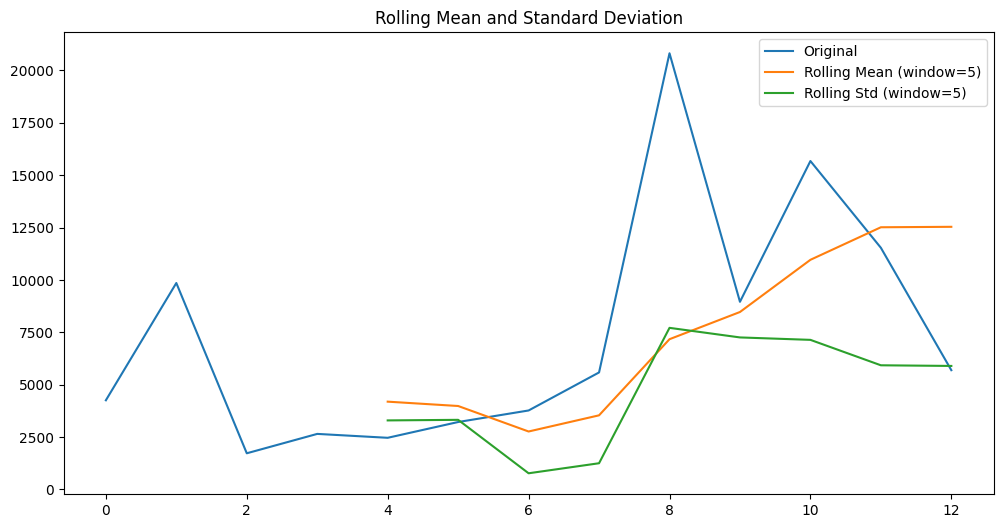

In [ ]:
plot_rolling_statistics(np.array(series), window=5)

## ADF

In [ ]:
hasil = adfuller(series)
hasil

(-2.421623106399714,
 0.1357262161081032,
 0,
 12,
 {'1%': -4.137829282407408,
  '5%': -3.1549724074074077,
  '10%': -2.7144769444444443},
 165.18003177440917)

Terlihat bahwa time series tidak stationary karena p-value > 0.05 serta nilai dari ADF stats > critical value pada tiap tingkat signifikasi sehingga perlu dilakukan transformasi atau pun differencing

In [ ]:
hasil[1]

0.1357262161081032

## Transforming

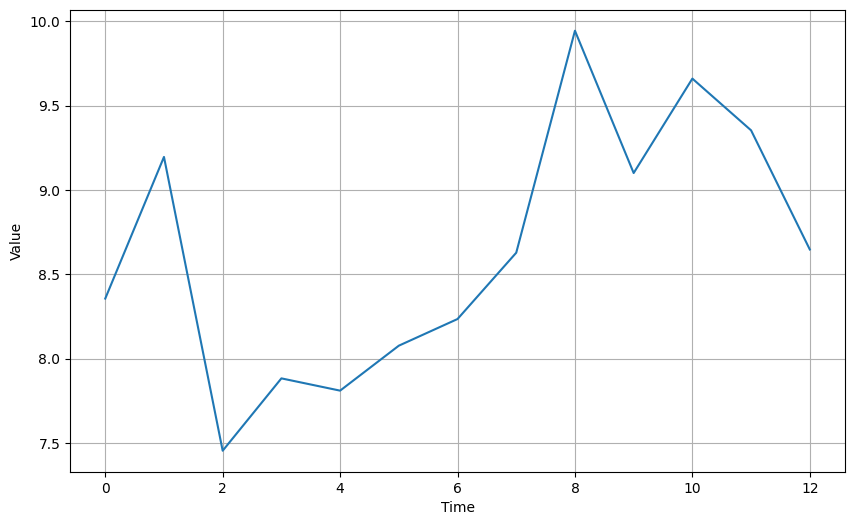

In [ ]:
quarterly['log_total'] = np.log(abs(quarterly['total']))
plot_series(time, quarterly['log_total'])

In [ ]:
adfuller(quarterly['log_total'])

(-1.9473582297587881,
 0.3101204977840132,
 0,
 12,
 {'1%': -4.137829282407408,
  '5%': -3.1549724074074077,
  '10%': -2.7144769444444443},
 16.559668404684828)

## Decomposition

In [ ]:
def check_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    return p_value

p_value = check_stationarity(series)
print(f"P-value sebelum differencing: {p_value}")
while p_value >= 0.05:
    series = series.diff().dropna()
    p_value = check_stationarity(series)

print(f"P-value setelah differencing: {p_value}")

P-value sebelum differencing: 0.1357262161081032
P-value setelah differencing: 3.139538972851959e-06


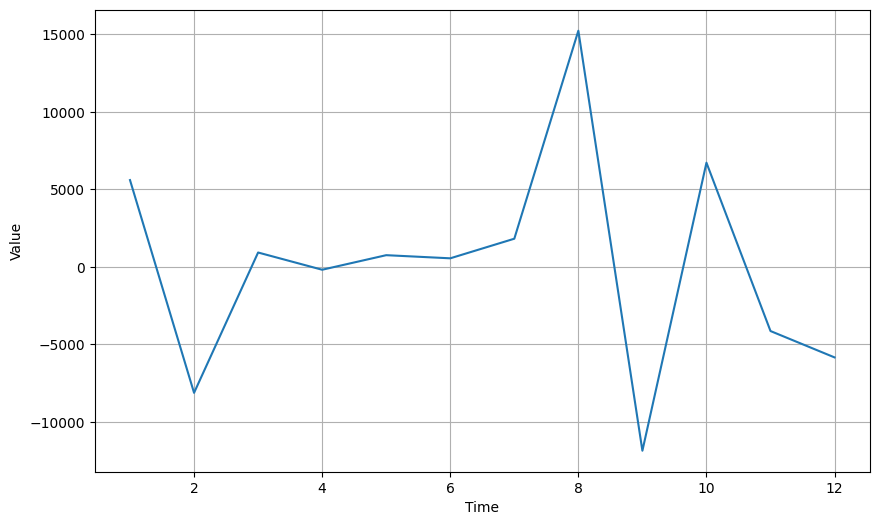

In [ ]:
plot_series(pd.RangeIndex(start=1, stop=13, step=1), series)

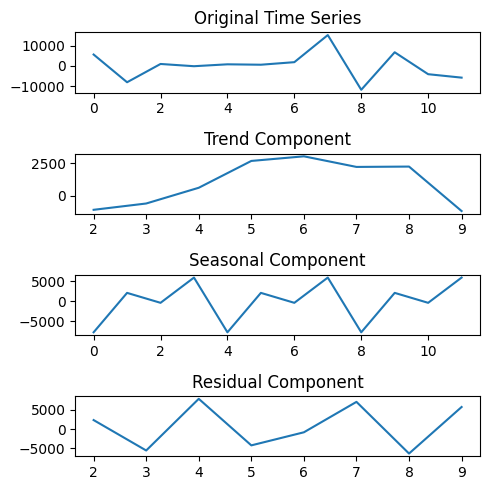

In [ ]:
plot_time_series_decomposition(np.array(series), freq=4)

## Autocorrelation

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


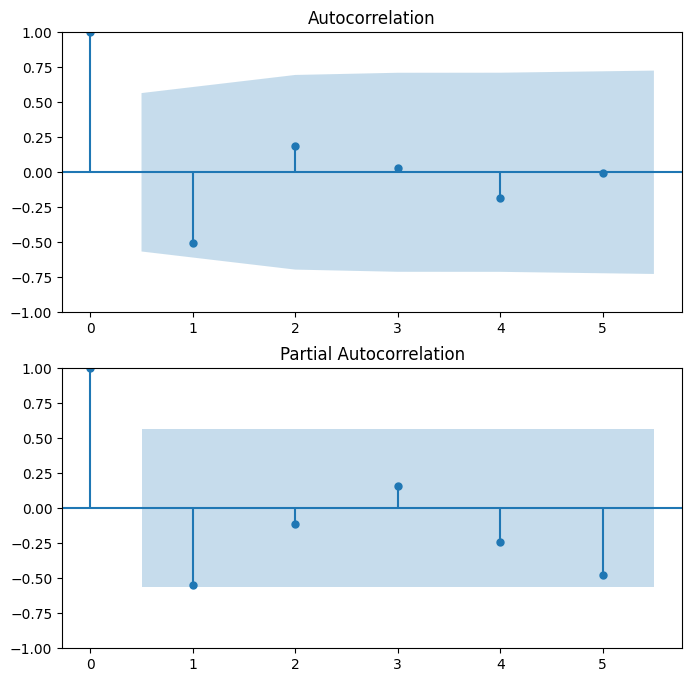

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

plot_acf(series, lags=5, ax=ax[0])
plot_pacf(series, lags=5, ax=ax[1])

plt.show()

## AR dan ARMA

In [ ]:
model = ARIMA(series, order=(1,0,0))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   12
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -121.240
Date:                Mon, 03 Jul 2023   AIC                            248.480
Time:                        02:23:57   BIC                            249.935
Sample:                             0   HQIC                           247.942
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        119.7500   1213.995      0.099      0.921   -2259.636    2499.136
ar.L1         -0.5207      0.419     -1.244      0.213      -1.341       0.300
sigma2      3.509e+07      0.089   3.95e+08      0.000    3.51e+07    3.51e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 5.51
Prob(Q):                              0.73   Prob(JB):                         0.06
Heteroskedasticity (H):               1.34   Skew:                             1.33
Prob(H) (two-sided):                  0.78   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=217.859, Time=0.79 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=233.523, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=224.039, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=231.726, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=219.792, Time=0.20 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=218.730, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0] intercept
Total fit time: 5.577 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMA

In [ ]:
series

1      5597.0
2     -8126.0
3       925.0
4      -186.0
5       753.0
6       551.0
7      1815.0
8     15231.0
9    -11860.0
10     6718.0
11    -4140.0
12    -5841.0
Name: total, dtype: float64

In [ ]:
predictions

0     2600.378380
1     3036.713939
2     4145.317344
3     2102.473911
4     2094.045470
5     2100.893578
6     2046.372099
7     2054.273763
8     2107.214909
9     2198.874207
10    2139.084952
11    2131.446678
12    2086.407195
13    2178.329882
14    2148.040171
15    2189.128822
16    2257.346518
17    2193.869820
18    2156.205224
19    2389.567689
20    2255.239408
21    2296.854836
22    2665.599138
23    2973.500630
24    3152.078228
25    5103.789141
26    2767.530599
27    2836.275072
28    2501.771312
29    2421.964510
30    2420.120788
31    5032.937557
32    2633.202317
33    3079.382923
34    3072.008037
35    2311.341219
36    2559.453457
Name: predicted_mean, dtype: float64

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


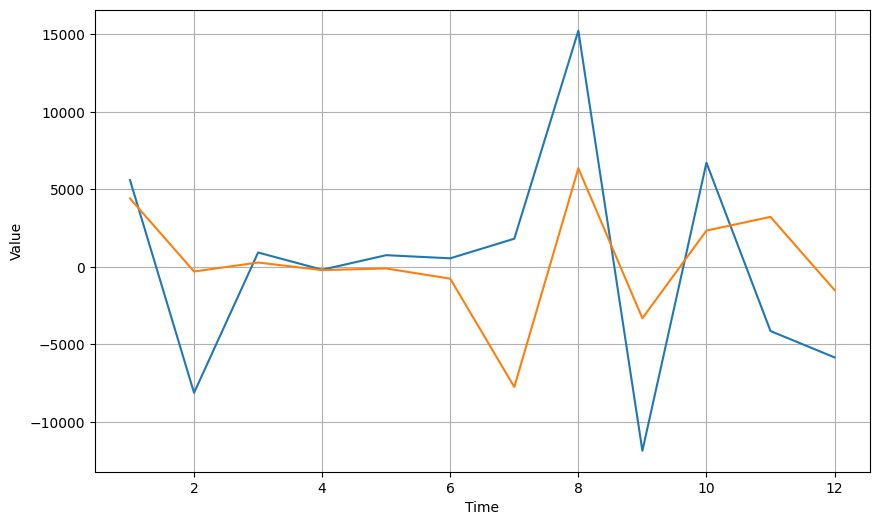

In [ ]:
predictions = model_fit.predict(start=1, end=13)
plot_series(pd.RangeIndex(start=1, stop=13, step=1), (series, predictions[1:13]))

In [ ]:
print('Quarterly')
mae = abs(series- predictions).mean()
mse = np.mean((series- predictions)**2)
rmse = np.sqrt(mse)
print("MAE:", mae)
print("RMSE:", rmse)

Quarterly
MAE: 7794.043792568561
RMSE: 10492.41213255854


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with

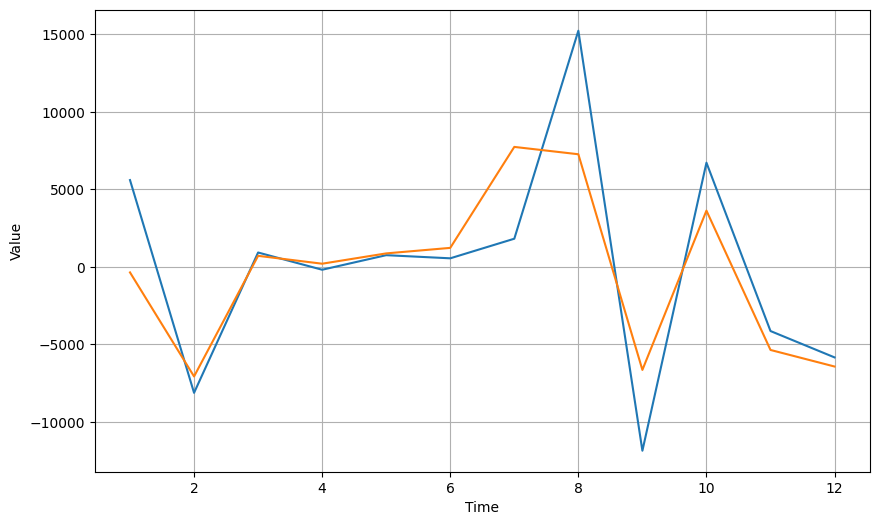

In [ ]:
model = ARIMA(series, order=(1,2,1))
model_fit = model.fit()
predictions = model_fit.predict(start=1, end=13)
plot_series(pd.RangeIndex(start=1, stop=13, step=1), (series, predictions[1:13]))

In [ ]:
print('Quarterly')
mae = abs(series- predictions).mean()
mse = np.mean((series- predictions)**2)
rmse = np.sqrt(mse)
print("MAE:", mae)
print("RMSE:", rmse)

Quarterly
MAE: 5597.256710489807
RMSE: 8100.990458820589


<ipython-input-164-ebe613f9c055>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_rolling = pd.Series()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starti

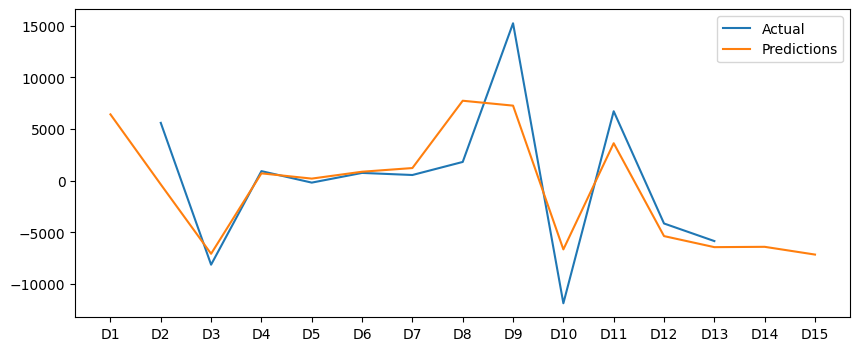

In [ ]:
prediction_rolling = pd.Series()
train_data = series
for end_date in pd.RangeIndex(start=1, stop=16, step=1):
    model = ARIMA(train_data, order=(1, 2, 1))
    model_fit = model.fit()
    pred = model_fit.predict(end_date, end_date)
    new_element = pred.iloc[0]  # Menggunakan .iloc untuk mengambil nilai pada indeks
    new_index = 'D' + str(end_date)  # Menambahkan nomor iterasi ke indeks
    prediction_rolling = prediction_rolling.append(pd.Series([new_element], index=[new_index]))

plt.figure(figsize=(10, 4))
plt.plot(series)
plt.plot(prediction_rolling)

plt.legend(["Actual", "Predictions"])
plt.show()

In [ ]:
result = adfuller(quarterly['total'])

# Menampilkan hasil ADF Test
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, ':', value)

ADF Statistic: -2.421623106399714
p-value: 0.1357262161081032
Critical Values:
1% : -4.137829282407408
5% : -3.1549724074074077
10% : -2.7144769444444443


In [ ]:
quarterly['total']

0      4257
1      9854
2      1728
3      2653
4      2467
5      3220
6      3771
7      5586
8     20817
9      8957
10    15675
11    11535
12     5694
Name: total, dtype: int64

In [ ]:
differenced_series = quarterly['total'].diff().dropna()
differenced_series

1      5597.0
2     -8126.0
3       925.0
4      -186.0
5       753.0
6       551.0
7      1815.0
8     15231.0
9    -11860.0
10     6718.0
11    -4140.0
12    -5841.0
Name: total, dtype: float64

In [ ]:
restored_series = series.iloc[0] + differenced_series.cumsum()

In [ ]:
restored_series

1     11194.0
2      3068.0
3      3993.0
4      3807.0
5      4560.0
6      5111.0
7      6926.0
8     22157.0
9     10297.0
10    17015.0
11    12875.0
12     7034.0
Name: total, dtype: float64

In [ ]:
diff = pm.utils.diff(quarterly['total'], lag=1, differences=1)
diff

array([  5597.,  -8126.,    925.,   -186.,    753.,    551.,   1815.,
        15231., -11860.,   6718.,  -4140.,  -5841.])

In [ ]:
pm.utils.diff_inv(prediction_rolling, lag=1, differences=1)

array([     0.        ,   6416.89606011,   6057.91487617,  -1011.69681784,
         -300.25997473,    -97.63355987,    770.36846707,   1994.39137045,
         9731.10460398,  16994.23969574,  10346.56268688,  13972.57192919,
         8612.22822367,   2183.09214538,  -4214.39203381, -11361.77817954])

## Kesimpulan
- Untuk prediksi monthly didapatkan model ARIMA(1,0,0) merupakan model terbaik, meskipun model ARIMA(0,1,1) dan AR dengan menggunakan lag ke-6 juga sama-sama memiliki RMSE sekitar 2600-2800-an.
- Hasil prediksi dari ketiga model berkisar dari 2500 sampai 3000 untuk tiga bulan ke depan.